# Feature Selection and Modeling

This notebook covers the basics of feature selection, modeling, and visualization for a classification problem.

## Libraries

Most of the libraries are required. **GuassianProcessClassifier**, **SVC**, and **GradientBoostingClassifier** are listed but not utilized explicitly. The latter two models take a considerable amount of time to run, so they are not shown here, but listed for those interested in considering what models were tried to solve this classification problem.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3

#Preprocessing and Feature Selection
from sklearn import preprocessing
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

#Classificatoin Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC

#Classification Models, Ensemble
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

#Metrics after fit()
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#YellowBrick Visualizers
from yellowbrick.target import BalancedBinningReference
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features.importances import FeatureImportances

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import Data

Data is available on [GitHub](https://github.com/georgetown-analytics/DC-Criminalistics).

In [2]:
conn = sqlite3.connect('../data/crime_census_weather_tod.db')        
df = pd.read_sql_query("select * from all_crimes", conn)
conn.close()

df.columns

Index(['level_0', 'BLOCK_GROUP', 'year', 'month', 'day', 'tod_cat', 'tod_num',
       'crime_counts', 'apparent_temp', 'cloud_cover', 'dew_point', 'humidity',
       'percip_intensity', 'percip_probability', 'pressure', 'temperature',
       'uv_index', 'visibility', 'wind_bearing', 'wind_gust', 'wind_speed',
       'weekday', 'index', 'TotalPop', 'TPopMargin', 'UnWgtSampleCtPop',
       'PerCapitaIncome', 'PerCapIncMargin', 'MedianHouseholdInc',
       'MedHouseholdIncMargin', 'MedianAge', 'MedianAgeMargin', 'HousingUnits',
       'HousingUnitsMargin', 'UnweightedSampleHousingUnits', 'State', 'County',
       'Tract', 'BlockGroup', 'census_year', 'crime_rate', 'crs',
       'crime_rate_cat'],
      dtype='object')

#### Drop missing values.

You do not always need to do this and this was only done here because the team wanted to try to include wind as a feature. In practice, with our data, you can skip this and drop wind, saving you 8,842 rows.

In [3]:
df_m = df.dropna(how='any')

print(len(df),len(df_m), len(df)-len(df_m))

188224 179382 8842


## Encode/Standardize Features

Encode Block Group using [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). An alternative would be to use [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). These are the only two ways that Block Group can be used in the model without explicitly leaking the answer.

*Know your encoder*. LabelEncoder sorts the labels before encoding them. You cannot reorder them before using LabelEncoder, unfortunately. You can keep the encoding, allowing you to go back and forth by running `.fit(data)` first explicitly, (separately from `.transform(data)`), and `pickle` the results of the fit.

#### Encode Blockgroup

In [4]:
le = preprocessing.LabelEncoder()
bg_fit = le.fit(df_m['BLOCK_GROUP'])

In [5]:
df_m['bg_cat'] = bg_fit.transform(df_m['BLOCK_GROUP'])

print(df_m.columns, len(df_m.columns))

Index(['level_0', 'BLOCK_GROUP', 'year', 'month', 'day', 'tod_cat', 'tod_num',
       'crime_counts', 'apparent_temp', 'cloud_cover', 'dew_point', 'humidity',
       'percip_intensity', 'percip_probability', 'pressure', 'temperature',
       'uv_index', 'visibility', 'wind_bearing', 'wind_gust', 'wind_speed',
       'weekday', 'index', 'TotalPop', 'TPopMargin', 'UnWgtSampleCtPop',
       'PerCapitaIncome', 'PerCapIncMargin', 'MedianHouseholdInc',
       'MedHouseholdIncMargin', 'MedianAge', 'MedianAgeMargin', 'HousingUnits',
       'HousingUnitsMargin', 'UnweightedSampleHousingUnits', 'State', 'County',
       'Tract', 'BlockGroup', 'census_year', 'crime_rate', 'crs',
       'crime_rate_cat', 'bg_cat'],
      dtype='object') 44


/Users/DanSchorer/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### Standardize

Standardization here means standardizing features, not targets. Standardizations tried were [StandardScalar](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), [Min-Max](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), and [Robust](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html). Ideally, (1) pick the scalar that gives you the *least amount of variance* in your features, and (2) *scale all features*. This may seem counter intuitive. Lastly, be sure to understand the scaler you chose, even if you don't understand the scaler you did not choose. StandardScaler is intuitive for those coming from a basic background in statistics.

Lastly, the team only planned on using features that were standardized. It is not necessary to have the standardized features equal the total number of features you plan to test in the modeling.

In [6]:
feature_std = [
    'year', 'month', 'day', 'tod_num',
    'cloud_cover', 'dew_point', 'humidity', 'percip_intensity',
    'percip_probability', 'pressure', 'temperature', 'uv_index',
    'visibility', 'wind_bearing', 'wind_gust', 'wind_speed',
    'PerCapitaIncome', 'MedianHouseholdInc', 'MedianAge', 'HousingUnits',
    'weekday', 'bg_cat'
]

scaler = preprocessing.StandardScaler()
scaler_df= pd.DataFrame(scaler.fit_transform(df_m[feature_std]), columns=feature_std)

print(len(feature_std))

22


### Feature Selection

Feature selection looks at feature ranking and feature importance for the random forest classifier. Other classifiers can be used, however.

In [7]:
feature_cols = [
    'year', 'month', 'day', 'tod_num',
    'cloud_cover', 'dew_point', 'humidity', 'percip_intensity',
    'percip_probability', 'pressure', 'temperature', 'uv_index',
    'visibility', 'wind_bearing', 'wind_gust', 'wind_speed',
    'PerCapitaIncome', 'MedianHouseholdInc', 'MedianAge',
    'weekday', 'bg_cat'
]

len(feature_cols)

21

In [8]:
features = scaler_df[feature_cols]
target = df_m['crime_rate_cat']

#### Feature ranking

Feature ranking with [recursive feature elimination and cross-validated (rfecv)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) selection for the best number of features.

Random Forest Classifier

In [9]:
rmf = RandomForestClassifier()
rfecv = RFECV(estimator=rmf,
              step=1,
              cv=StratifiedKFold(2), #Set to 12 for production.
              scoring='accuracy',
              verbose=10,
              n_jobs=-1)

In [10]:
rfecv.fit(features, target)
print(rfecv.n_features_)

Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
8


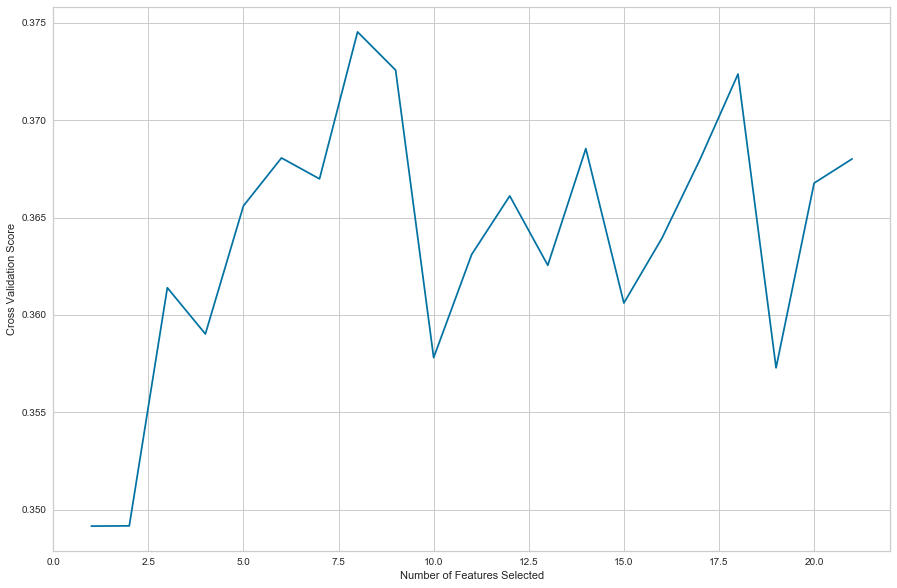

In [11]:
plt.figure(figsize=(15, 10))
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross Validation Score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [12]:
for index in np.where(rfecv.support_)[0]:
    print(features.columns[index])

year
temperature
visibility
wind_gust
PerCapitaIncome
MedianHouseholdInc
MedianAge
bg_cat


#### Feature Importances

Feature Importances are visualized using YellowBrick's [FeatureImportances visualizer](https://www.scikit-yb.org/en/latest/api/features/importances.html) and the random forest classifier.

Random Forest Classifier

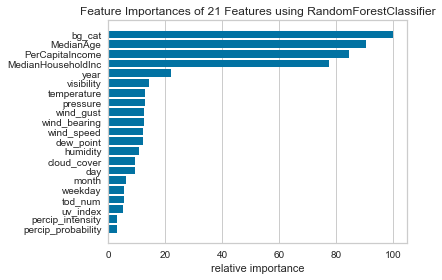

In [13]:
fig = plt.figure()
ax = fig.add_subplot()

viz = FeatureImportances(RandomForestClassifier(), ax=ax)
viz.fit(features, target)
viz.poof()

## Modeling

#### Split Data: Test, Train

The team split up the data using scikit-learn's [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) functionality. Classes were listed, as required by YellowBrick.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

In [10]:
classes=list(target.unique())
classes

['Med', 'High', 'Med-High', 'Low', 'Low-Med']

#### Pick Models

- Decision Tree Classifier
- K-Nearest Neighbors Classifier
- Random Forest Classifier
- Extra Tree Classifier
- Bagging Classifier with Decision Tree Classifier Estimator (Default value)
- Bagging Classifier with Random Forest Classifier Estimator

Generally, all models had high accuracy, but an inability to decipher between High and High-Medium and Medium. There are a few approaches the team could have used in the way of hyper-parameter and stratification to tease out the relationship. The alternative is that the relationship is simply not strong enough to be noticed by our models.

Notice Bagging Classifier takes an estimator as an argument. I point this out because Bagging Classifier, if used naively, would cause one to think it is itself a classifier. Really, it is an approach to selecting data to classify (Bagging = Bootstrapping), but a separate estimator is always required (default is decision tree).

**Pro-tip:** *fit all models first and save them in a dictionary*, as seen below. This way, if you want to change anything about how one produces visualizations, you do not need to re-fit the models. *Do not change the test-train splits.*

In [11]:
#['GradientBoosting'GradientBoostingClassifier()],
#['SVC',SVC()]
#['GuassianClassifier',GaussianProcessClassifier()]

models_list = [
    ['DecisionTreeClassifier', DecisionTreeClassifier()],
    ['KNeighborsClassifier',KNeighborsClassifier()],
    ['RandomForestClassifier',RandomForestClassifier()],
    ['ExtraTreesClassifier',ExtraTreesClassifier()],
    ['BC_Decision',BaggingClassifier(base_estimator=DecisionTreeClassifier())],
    ['BC_RMF',BaggingClassifier(base_estimator=RandomForestClassifier())],
]

In [12]:
%%time

models_dict = {}

for name, model in models_list:
    try:
        fit = model.fit(X_train, y_train)
        
        models_dict[name] = fit
        
        print("{} fitted".format(name))

    except Exception as e:
        print("{} failed; {}.".format(name, e))

        pass

DecisionTreeClassifier fitted
KNeighborsClassifier fitted
RandomForestClassifier fitted
ExtraTreesClassifier fitted
BC_Decision fitted
BC_RMF fitted
CPU times: user 1min 53s, sys: 909 ms, total: 1min 54s
Wall time: 1min 54s


#### Classification Reports

[Classification reports](https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html) are a fantastic review tool by YellowBrick.

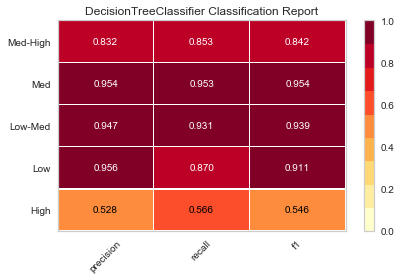

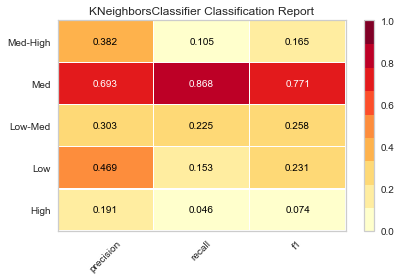

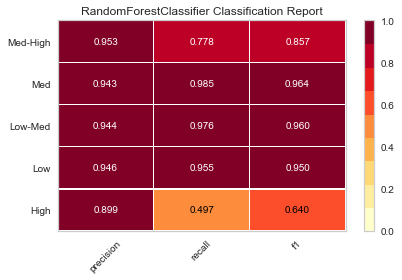

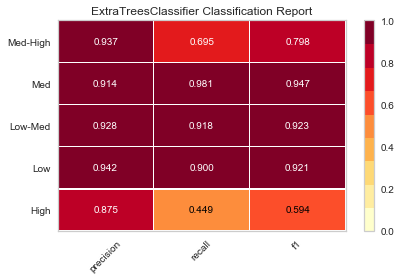

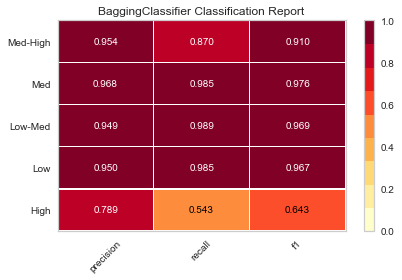

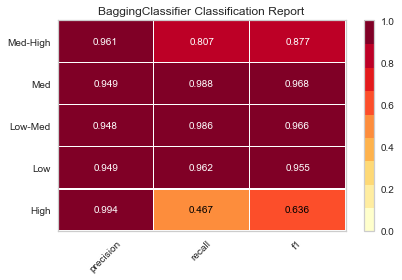

In [14]:
for name, model in models_dict.items():
    cr = ClassificationReport(model, classes=None)
    cr.score(X_test, y_test)
    cr.poof()

#### Confusion Matrix

[ConfusionMatrix](https://www.scikit-yb.org/en/latest/api/classifier/confusion_matrix.html) is another fantastic tool by YellowBrick. This is made available by scikit-learn ([Confusion Matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)), but not with the visualizations.

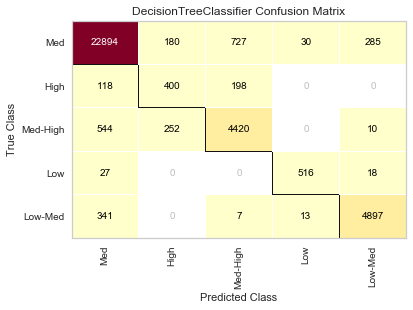

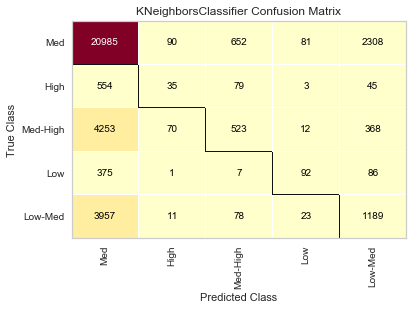

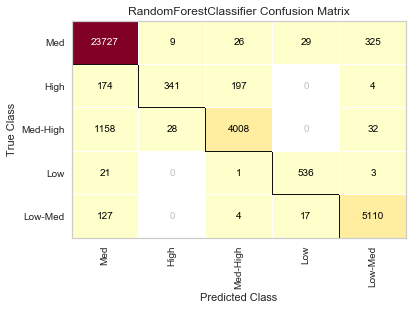

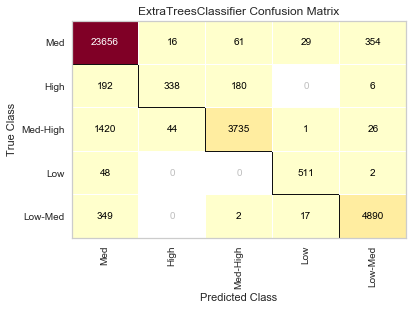

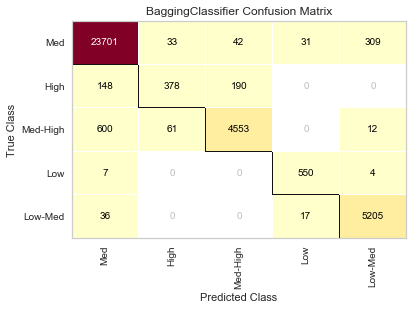

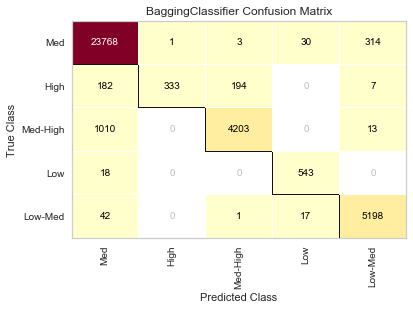

In [19]:
for name, model in models_dict.items():
    cm = ConfusionMatrix(model, classes=classes)
    cm.score(X_test, y_test)
    cm.poof()